## It aggregates data from multiple sources into a single dataset and simple MLP and LogisticRegression.

### Necessary library imports

In [1]:
import pandas as pd
import _sqlite3 as db
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import sklearn as sk
import sklearn.metrics as metrics
from regex import Match
from sklearn.metrics import roc_curve, auc, precision_recall_curve

### Extraction data from sqlite DB

In [7]:
# function for tables extraction
def extract_tables(cursor):
    for row in cursor.execute("SELECT name FROM sqlite_master WHERE type='table';"):
        print(row)

# Extraction tables from European Soccer Database (https://www.kaggle.com/datasets/hugomathien/soccer?resource=download)
con_euro = db.connect('Data/EuroSoccer.sqlite')
cursor = con_euro.cursor()

print("Tables from European Soccer Database:\n")
extract_tables(cursor)
print('\n')

# Extraction tables from World Soccer DB: archive of odds [01-JUN-2021] (https://www.kaggle.com/datasets/sashchernuh/european-football/data?select=database.sqlite)
con_world = db.connect('Data/WorldSoccer.sqlite')
cursor = con_world.cursor()

print("Tables from WorldSoccer Database:\n")
extract_tables(cursor)


Tables from European Soccer Database:

('sqlite_sequence',)
('Player_Attributes',)
('Player',)
('Match',)
('League',)
('Country',)
('Team',)
('Team_Attributes',)




OperationalError: unable to open database file

### Extraction data from tables and .csv files to DataFrames

In [5]:
# Extraction data from Euro Soccer
match_table = pd.read_sql_query("SELECT * FROM Match;", con_euro)
team_table = pd.read_sql_query("SELECT * FROM Team;", con_euro)
team_attributes = pd.read_sql_query("SELECT * FROM Team_Attributes;", con_euro)
country_table = pd.read_sql_query("SELECT * FROM Country;", con_euro)
players = pd.read_sql_query("SELECT * FROM Player;", con_euro)
player_attributes = pd.read_sql_query("SELECT * FROM Player_Attributes;", con_euro)
leagues_table = pd.read_sql_query("SELECT * FROM League;", con_euro)

# Extraction data from World Soccer
betfront = pd.read_sql_query("SELECT * FROM betfront;", con_world)
football_data = pd.read_sql_query("SELECT * FROM football_data;", con_world)

# Extraction data from Football Players Data/fifa_players.csv (https://www.kaggle.com/datasets/maso0dahmed/football-players-data)
fifa_players = pd.read_csv('Data/fifa_players.csv')

# Extraction data from International football results from 1872 to 2025 (https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017/data?select=former_names.csv)
former_names = pd.read_csv('Data/former_names.csv')
goalscorers = pd.read_csv('Data/goalscorers.csv')
shootouts = pd.read_csv('Data/shootouts.csv')
results = pd.read_csv('Data/results.csv')

# Look up of all data
print(f"match_table: {match_table.columns.tolist()}\n")
print(f"team_table: {team_table.columns.tolist()}\n")
print(f"team_attributes: {team_attributes.columns.tolist()}\n")
print(f"country_table: {country_table.columns.tolist()}\n")
print(f"players: {players.columns.tolist()}\n")
print(f"player_attributes: {player_attributes.columns.tolist()}\n")
print(f"leagues: {leagues_table.columns.tolist()}\n")

print(f"betfront: {betfront.columns.tolist()}\n")
print(f"football_data: {football_data.columns.tolist()}\n")
print(f"fifa_players: {fifa_players.columns.tolist()}\n")
print(f"former_names: {former_names.columns.tolist()}\n")
print(f"shootouts: {shootouts.columns.tolist()}\n")
print(f"results: {results.columns.tolist()}\n")

match_table: ['id', 'country_id', 'league_id', 'season', 'stage', 'date', 'match_api_id', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal', 'home_player_X1', 'home_player_X2', 'home_player_X3', 'home_player_X4', 'home_player_X5', 'home_player_X6', 'home_player_X7', 'home_player_X8', 'home_player_X9', 'home_player_X10', 'home_player_X11', 'away_player_X1', 'away_player_X2', 'away_player_X3', 'away_player_X4', 'away_player_X5', 'away_player_X6', 'away_player_X7', 'away_player_X8', 'away_player_X9', 'away_player_X10', 'away_player_X11', 'home_player_Y1', 'home_player_Y2', 'home_player_Y3', 'home_player_Y4', 'home_player_Y5', 'home_player_Y6', 'home_player_Y7', 'home_player_Y8', 'home_player_Y9', 'home_player_Y10', 'home_player_Y11', 'away_player_Y1', 'away_player_Y2', 'away_player_Y3', 'away_player_Y4', 'away_player_Y5', 'away_player_Y6', 'away_player_Y7', 'away_player_Y8', 'away_player_Y9', 'away_player_Y10', 'away_player_Y11', 'home_player_1', 'home_player_2', 

### Creating labels

In [6]:
def create_match_result(row):
    if row['home_team_goal'] > row['away_team_goal']:
        return 1  # Home win
    elif row['home_team_goal'] < row['away_team_goal']:
        return -1  # Away win
    else:
        return 0  # Draw

match_table['result'] = match_table.apply(create_match_result, axis=1)
match_table['result_label'] = match_table['result'].map({1: 'home_win', 0: 'draw', -1: 'away_win'})

### The main combination of match data with information about teams and leagues

In [7]:
matches_enhanced = match_table.merge(
    leagues_table, left_on='league_id', right_on='id', how='left', suffixes=('', '_league')
).merge(
    country_table, left_on='country_id', right_on='id', how='left', suffixes=('', '_country')
)
matches_enhanced = matches_enhanced.merge(
    team_table, left_on='home_team_api_id', right_on='team_api_id',
    how='left', suffixes=('', '_home_team')
)
matches_enhanced.rename(columns={
    'team_long_name': 'home_team_name',
    'team_short_name': 'home_team_short'
}, inplace=True)
matches_enhanced = matches_enhanced.merge(
    team_table, left_on='away_team_api_id', right_on='team_api_id',
    how='left', suffixes=('', '_away_team')
)
matches_enhanced.rename(columns={
    'team_long_name': 'away_team_name',
    'team_short_name': 'away_team_short'
}, inplace=True)

print(f"The main dataset has been created: {matches_enhanced.shape}")

The main dataset has been created: (25979, 132)


### Function to extract data about players for specific match

In [9]:
def get_match_players(match_row, team_type='home'):
    player_columns = [f'{team_type}_player_{i}' for i in range(1, 12)]
    players = []
    for col in player_columns:
        if col in match_row and pd.notna(match_row[col]):
            players.append(int(match_row[col]))
    return players

def get_players_attributes_for_match(player_ids, match_date, player_attributes):
    if not player_ids:
        return pd.DataFrame()
    match_date = pd.to_datetime(match_date)
    relevant_attributes = player_attributes[
        player_attributes['player_api_id'].isin(player_ids)
    ].copy()

    if relevant_attributes.empty:
        return pd.DataFrame()
    relevant_attributes['date'] = pd.to_datetime(relevant_attributes['date'])
    player_attrs_list = []
    for player_id in player_ids:
        player_data = relevant_attributes[
            (relevant_attributes['player_api_id'] == player_id) &
            (relevant_attributes['date'] <= match_date)
        ]

        if not player_data.empty:
            latest_attr = player_data.loc[player_data['date'].idxmax()]
            player_attrs_list.append(latest_attr)

    if player_attrs_list:
        return pd.DataFrame(player_attrs_list)
    else:
        return pd.DataFrame()
def aggregate_team_player_stats(team_players_attrs):
    if team_players_attrs.empty:
        return {}
    key_attributes = [
        'overall_rating', 'potential', 'crossing', 'finishing', 'heading_accuracy',
        'short_passing', 'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
        'agility', 'shot_power', 'stamina', 'strength', 'aggression', 'interceptions',
        'positioning', 'vision', 'marking', 'standing_tackle', 'sliding_tackle'
    ]

    aggregated_stats = {}
    for attr in key_attributes:
        if attr in team_players_attrs.columns and not team_players_attrs[attr].isna().all():
            aggregated_stats[f'{attr}_mean'] = team_players_attrs[attr].mean()
            aggregated_stats[f'{attr}_max'] = team_players_attrs[attr].max()
            aggregated_stats[f'{attr}_min'] = team_players_attrs[attr].min()
            aggregated_stats[f'{attr}_std'] = team_players_attrs[attr].std()
    if 'preferred_foot' in team_players_attrs.columns:
        foot_counts = team_players_attrs['preferred_foot'].value_counts()
        aggregated_stats['right_foot_players'] = foot_counts.get('right', 0)
        aggregated_stats['left_foot_players'] = foot_counts.get('left', 0)
    if 'attacking_work_rate' in team_players_attrs.columns:
        work_rate_counts = team_players_attrs['attacking_work_rate'].value_counts()
        aggregated_stats['high_attack_work_rate'] = work_rate_counts.get('high', 0)
        aggregated_stats['medium_attack_work_rate'] = work_rate_counts.get('medium', 0)
        aggregated_stats['low_attack_work_rate'] = work_rate_counts.get('low', 0)
    if 'defensive_work_rate' in team_players_attrs.columns:
        def_work_rate_counts = team_players_attrs['defensive_work_rate'].value_counts()
        aggregated_stats['high_defence_work_rate'] = def_work_rate_counts.get('high', 0)
        aggregated_stats['medium_defence_work_rate'] = def_work_rate_counts.get('medium', 0)

    return aggregated_stats

### A function to get the closest attributes of a team to the match date

In [10]:
def get_team_attributes_for_match(match_date, team_api_id, team_attributes):
    team_attrs = team_attributes[team_attributes['team_api_id'] == team_api_id].copy()
    if team_attrs.empty:
        return pd.Series()

    team_attrs['date'] = pd.to_datetime(team_attrs['date']) # date representation
    match_date = pd.to_datetime(match_date)
    valid_attrs = team_attrs[team_attrs['date'] <= match_date] # Находим ближайшие атрибуты до даты матча
    if valid_attrs.empty:
        return team_attrs.iloc[0]

    return valid_attrs.loc[valid_attrs['date'].idxmax()]

### Creating a composite dataset

In [ ]:
def create_comprehensive_ml_dataset(matches_df, team_attributes, player_attributes):
    # Base copy and light preprocessing
    ml = matches_df.copy()
    ml['season_encoded'] = ml['season'].str.replace('/', '').astype(int)
    ml['stage'] = ml['stage'].fillna(0)

    feature_rows = []
    total = len(ml)
    for idx, match in ml.iterrows():
        if idx % 3000 == 0:
            print(f"Processed {idx} from {total}")

        # 1) Team features
        home_attr = get_team_attributes_for_match(match['date'], match['home_team_api_id'], team_attributes)
        away_attr = get_team_attributes_for_match(match['date'], match['away_team_api_id'], team_attributes)

        # 2) Player features
        home_players = get_match_players(match, 'home')
        away_players = get_match_players(match, 'away')
        home_player_stats = aggregate_team_player_stats(
            get_players_attributes_for_match(home_players, match['date'], player_attributes)
        )
        away_player_stats = aggregate_team_player_stats(
            get_players_attributes_for_match(away_players, match['date'], player_attributes)
        )

        # 3) Build one flat dict of all features for this match
        row = {}
        # team metrics
        for col in [
            'buildUpPlaySpeed','buildUpPlayPassing','chanceCreationPassing',
            'chanceCreationCrossing','chanceCreationShooting','defencePressure',
            'defenceAggression','defenceTeamWidth'
        ]:
            row[f'home_{col}'] = home_attr.get(col, np.nan)
            row[f'away_{col}'] = away_attr.get(col, np.nan)
        # player metrics (whatever keys appear)
        for key, val in home_player_stats.items():
            row[f'home_player_{key}'] = val
        for key, val in away_player_stats.items():
            row[f'away_player_{key}'] = val

        feature_rows.append(row)

    # 4) One‐shot DataFrame creation + concat
    features_df = pd.DataFrame(feature_rows, index=ml.index)
    comprehensive = pd.concat([ml, features_df], axis=1)

    print(f"Comprehensive dataset shape: {comprehensive.shape}")
    return comprehensive

comprehensive_dataset = create_comprehensive_ml_dataset(
    matches_enhanced, team_attributes, player_attributes
)

print(f"A comprehensive dataset has been created: {comprehensive_dataset.shape}")

Processed 0 from 25979
Processed 3000 from 25979


### Analyze data in our new dataset by number of  NaN

In [203]:
comprehensive_dataset['result'] = comprehensive_dataset.apply(create_match_result, axis=1)
comprehensive_dataset['result_label'] = comprehensive_dataset['result'].map({1: 'home_win', 0: 'draw', -1: 'away_win'})

rows_with_nan = comprehensive_dataset.isnull().any(axis=1).sum()
total_rows = len(comprehensive_dataset)
rows_without_nan = total_rows - rows_with_nan

print(f"Number of notes with NaN: {rows_with_nan}")
print(f"Overall number of notes in dataset: {total_rows}")

def analyze_missing_data(df):
    # Топ колонок с наибольшим количеством NaN
    nan_by_column = df.isnull().sum().sort_values(ascending=False)
    print(f"\nTop 50 lines by number of NaN:")
    print(nan_by_column.head(50))

    rows_with_nan = df.isnull().any(axis=1).sum()
    print(f"\nNumber of notes with at least one NaN: {rows_with_nan} из {len(df)}")

    complete_rows = len(df) - rows_with_nan
    print(f"Full notes: {complete_rows}")

analyze_missing_data(comprehensive_dataset)

Number of notes with NaN: 24217
Overall number of notes in dataset: 25979

Top 50 lines by number of NaN:
PSH                14811
PSD                14811
PSA                14811
BSH                11818
BSA                11818
BSD                11818
GBH                11817
GBA                11817
GBD                11817
card               11762
shoton             11762
corner             11762
possession         11762
cross              11762
foulcommit         11762
shotoff            11762
goal               11762
SJA                 8882
SJH                 8882
SJD                 8882
IWA                 3459
IWH                 3459
IWD                 3459
LBH                 3423
LBD                 3423
LBA                 3423
VCA                 3411
VCD                 3411
VCH                 3411
WHH                 3408
WHA                 3408
WHD                 3408
BWA                 3404
BWH                 3404
BWD                 3404
B365D              

### Drop top N NaN columns

In [204]:
def drop_top_n_nan_columns(df, n):
    nan_counts = df.isnull().sum().sort_values(ascending=False)
    top_nan_cols = nan_counts.head(n).index.tolist()
    df_dropped = df.drop(columns=top_nan_cols) # drop tables
    return df_dropped, top_nan_cols, nan_counts.head(n)

dropped_df, dropped_cols, nan_stats = drop_top_n_nan_columns(comprehensive_dataset, n=35)

print("Cleaning results") # Results Analysing
print(f"Default size: {comprehensive_dataset.shape}")
print(f"Size after cleaning: {dropped_df.shape}")
print(f"Number of deleted tables: {len(dropped_cols)}")

total_nan_after = dropped_df.isnull().sum().sum() # NaN calculation
rows_with_nan_after = dropped_df.isnull().any(axis=1).sum()
complete_rows_after = len(dropped_df) - rows_with_nan_after

print(f"\nCurrent number of NaN: {total_nan_after}")
print(f"Number of notes with at least one NaN: {rows_with_nan_after} from {len(dropped_df)}")
print(f"Full notes: {complete_rows_after} ({complete_rows_after/len(dropped_df)*100:.1f}%)")
print(f"\nTop - 10 deleted columns: {len(dropped_cols)}:")
print(nan_stats.head(10))

analyze_missing_data(dropped_df)

print(f"Current number of columns: {len(dropped_df.columns.tolist())}")

Cleaning results
Default size: (25979, 331)
Size after cleaning: (25979, 296)
Number of deleted tables: 35

Current number of NaN: 261445
Number of notes with at least one NaN: 6376 from 25979
Full notes: 19603 (75.5%)

Top - 10 deleted columns: 35:
PSH     14811
PSD     14811
PSA     14811
BSH     11818
BSA     11818
BSD     11818
GBH     11817
GBA     11817
GBD     11817
card    11762
dtype: int64

Top 50 lines by number of NaN:
B365H              3387
B365D              3387
B365A              3387
away_player_Y11    1839
away_player_X11    1839
away_player_X10    1833
away_player_X9     1833
away_player_Y10    1833
away_player_Y9     1833
away_player_X3     1832
away_player_X4     1832
away_player_X6     1832
away_player_X7     1832
away_player_X8     1832
away_player_X5     1832
home_player_Y6     1832
home_player_Y5     1832
home_player_Y4     1832
home_player_Y3     1832
home_player_Y10    1832
home_player_X7     1832
away_player_Y5     1832
away_player_Y4     1832
away_player_Y

### Checking for Key Features in dataset

In [205]:
base_features = ['stage', 'season_encoded', 'result_label']
team_feature_columns = [
    'home_buildUpPlaySpeed', 'home_buildUpPlayPassing', 'home_chanceCreationPassing',
    'home_chanceCreationCrossing', 'home_chanceCreationShooting', 'home_defencePressure',
    'home_defenceAggression', 'home_defenceTeamWidth',
    'away_buildUpPlaySpeed', 'away_buildUpPlayPassing', 'away_chanceCreationPassing',
    'away_chanceCreationCrossing', 'away_chanceCreationShooting', 'away_defencePressure',
    'away_defenceAggression', 'away_defenceTeamWidth'
]
betting_features = ['B365H', 'B365D', 'B365A']
key_player_stats = [
    'overall_rating_mean', 'overall_rating_max', 'potential_mean',
    'finishing_mean', 'short_passing_mean', 'long_passing_mean',
    'ball_control_mean', 'acceleration_mean', 'sprint_speed_mean',
    'shot_power_mean', 'stamina_mean', 'strength_mean',
    'aggression_mean', 'positioning_mean', 'vision_mean',
    'marking_mean', 'standing_tackle_mean',
    'right_foot_players', 'left_foot_players'
]
player_features = []
for stat in key_player_stats:
    player_features.extend([f'home_player_{stat}', f'away_player_{stat}'])

all_features = base_features + team_feature_columns + betting_features + player_features
# all_features = [
#     'stage', 'season_encoded',
#     'home_buildUpPlaySpeed', 'home_buildUpPlayPassing', 'home_chanceCreationPassing',
#     'home_chanceCreationCrossing', 'home_chanceCreationShooting', 'home_defencePressure',
#     'home_defenceAggression', 'home_defenceTeamWidth',
#     'away_buildUpPlaySpeed', 'away_buildUpPlayPassing', 'away_chanceCreationPassing',
#     'away_chanceCreationCrossing', 'away_chanceCreationShooting', 'away_defencePressure',
#     'away_defenceAggression', 'away_defenceTeamWidth', 'result_label','B365H', 'B365D', 'B365A'
# ]
available_features = [f for f in all_features if f in dropped_df]
missing_features = [f for f in all_features if f not in dropped_df]

print(f"Total requested attributes: {len(all_features)}")
print(f"Available features: {len(available_features)}")
print(f"Missing features: {len(missing_features)}")

if missing_features:
    print(f"Top 10 missing features: {missing_features[:10]}")

Total requested attributes: 60
Available features: 60
Missing features: 0


### Exploratory Data Analysis (EDA) and Preprocessing

In [3]:
X = dropped_df[all_features].dropna().reset_index(drop=True)
y = X['result_label'].map({'home_win': 0, 'away_win': 1, 'draw': 2}).values
X = X.drop(columns=['result_label']).values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.7, stratify=y, random_state=91)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=91)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

NameError: name 'dropped_df' is not defined

### Baseline MLP (Fully-Connected Network)

Epoch 1: Train Loss=1.0811, Acc=0.3656 | Val Loss=1.0635, Acc=0.3801
Epoch 2: Train Loss=1.0453, Acc=0.3881 | Val Loss=1.0475, Acc=0.4182
Epoch 3: Train Loss=1.0275, Acc=0.4150 | Val Loss=1.0385, Acc=0.4176
Epoch 4: Train Loss=1.0296, Acc=0.4099 | Val Loss=1.0417, Acc=0.4039
Epoch 5: Train Loss=1.0221, Acc=0.4129 | Val Loss=1.0386, Acc=0.3999
Epoch 6: Train Loss=1.0190, Acc=0.4196 | Val Loss=1.0367, Acc=0.4133
Epoch 7: Train Loss=1.0132, Acc=0.4268 | Val Loss=1.0355, Acc=0.4176
Epoch 8: Train Loss=1.0101, Acc=0.4332 | Val Loss=1.0385, Acc=0.4036
Epoch 9: Train Loss=1.0134, Acc=0.4274 | Val Loss=1.0385, Acc=0.4024
Epoch 10: Train Loss=1.0128, Acc=0.4253 | Val Loss=1.0375, Acc=0.3945
Epoch 11: Train Loss=1.0126, Acc=0.4231 | Val Loss=1.0360, Acc=0.4018
Epoch 12: Train Loss=1.0064, Acc=0.4278 | Val Loss=1.0398, Acc=0.4009
Epoch 13: Train Loss=1.0091, Acc=0.4341 | Val Loss=1.0356, Acc=0.4002
Epoch 14: Train Loss=1.0098, Acc=0.4298 | Val Loss=1.0400, Acc=0.3981
Epoch 15: Train Loss=1.0072, 

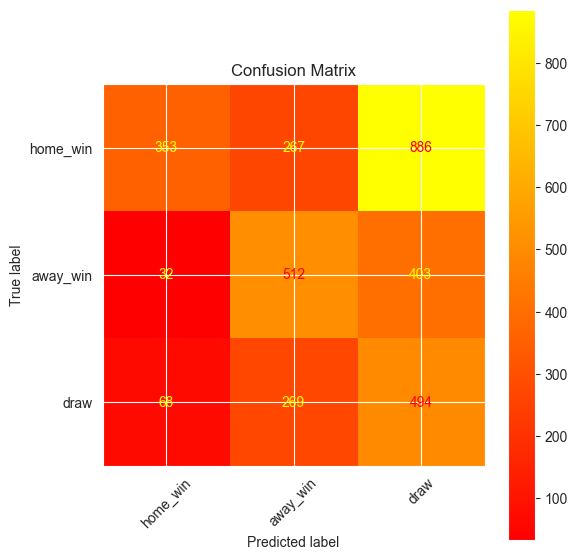

In [233]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.LongTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.LongTensor(y_test)

# Create DataLoader for batches
class_counts = np.bincount(y_train)
sample_weights = 1.0 / class_counts[y_train]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)

# MLP architecture
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size // 2, num_classes)
        )

    def forward(self, x):
        return self.model(x)

input_size = X_train.shape[1]
hidden_size = 32
num_classes = 3
learning_rate = 5e-4
num_epochs = 100

model = MLPClassifier(input_size, hidden_size, num_classes).to(device)

# Loss and optimizor
class_weights = torch.tensor(len(y_train) / (3 * class_counts), dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)

# Early stopping
best_val_loss = float('inf')
early_stopping_counter = 0
patience = 10

train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * y_batch.size(0)
        correct += (outputs.argmax(1) == y_batch).sum().item()
        total += y_batch.size(0)

    train_losses.append(total_loss / total)
    train_accs.append(correct / total)

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor.to(device))
        val_loss = criterion(val_outputs, y_val_tensor.to(device)).item()
        val_preds = val_outputs.argmax(1)
        val_acc = (val_preds == y_val_tensor.to(device)).float().mean().item()

    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Acc={train_accs[-1]:.4f} | Val Loss={val_loss:.4f}, Acc={val_acc:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pt")
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early stopping triggered.")
            break

# Uploading the best model
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# Test
with torch.no_grad():
    test_preds = model(X_test_tensor.to(device)).argmax(1).cpu().numpy()

print("\nClassification Report:")
print(classification_report(y_test, test_preds, target_names=['home_win', 'away_win', 'draw']))

cm = confusion_matrix(y_test, test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['home_win', 'away_win', 'draw'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap="autumn", colorbar=True)
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Logistic Regression

Fitting 8 folds for each of 10 candidates, totalling 80 fits
Best Params: {'C': 0.01, 'solver': 'lbfgs'}
Validation Classification Report:
              precision    recall  f1-score   support

    home_win       0.63      0.54      0.58      1506
    away_win       0.47      0.55      0.51       947
        draw       0.29      0.31      0.30       830

    accuracy                           0.49      3283
   macro avg       0.46      0.47      0.46      3283
weighted avg       0.50      0.49      0.49      3283


Test Classification Report:
              precision    recall  f1-score   support

    home_win       0.64      0.51      0.57      1506
    away_win       0.49      0.56      0.52       947
        draw       0.30      0.36      0.33       831

    accuracy                           0.49      3284
   macro avg       0.48      0.48      0.47      3284
weighted avg       0.51      0.49      0.50      3284



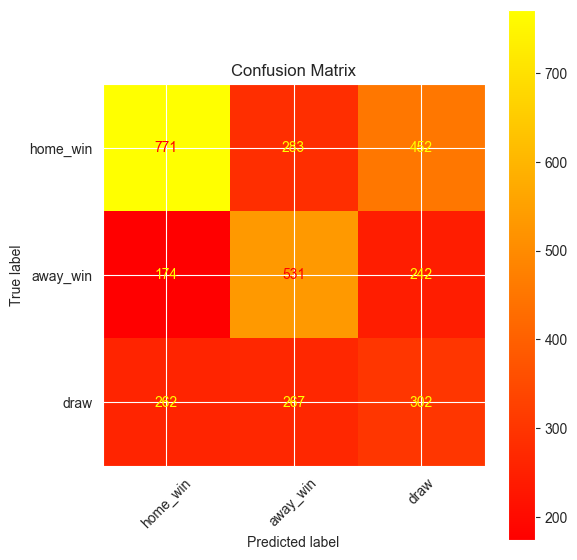

In [235]:
Sclass_counts = np.bincount(y_train)
class_weights = {i: len(y_train) / (3 * c) for i, c in enumerate(class_counts)}

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'saga'],
}

logreg = LogisticRegression(
    class_weight=class_weights,
    max_iter=1000,
    random_state=91
)

grid_search = GridSearchCV(logreg, param_grid, cv=8, scoring='f1_macro', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)
best_clf = grid_search.best_estimator_
print("Best Params:", grid_search.best_params_)

# Test
val_preds = best_clf.predict(X_val_scaled)
test_preds = best_clf.predict(X_test_scaled)

print("Validation Classification Report:")
print(classification_report(y_val, val_preds, target_names=['home_win', 'away_win', 'draw']))
print("\nTest Classification Report:")
print(classification_report(y_test, test_preds, target_names=['home_win', 'away_win', 'draw']))

# Confusion matrix
cm = confusion_matrix(y_test, test_preds, labels=[0, 1, 2])
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['home_win', 'away_win', 'draw'])
disp.plot(ax=ax, cmap="autumn", colorbar=True)
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Upload data to .csv

In [229]:
comprehensive_dataset.to_csv("comprehensive_dataset.csv")

In [1]:
import joblib
import json

# Saving the best Logistic Regression model
joblib.dump(best_clf, 'best_logistic_model.pkl')

# Saving of scaler
joblib.dump(scaler, 'scaler.pkl')

# Saving of features
feature_list = [f for f in available_features if f != 'result_label']
with open('features.json', 'w') as f:
    json.dump(feature_list, f)

# Saving of class mapping
class_mapping = {'home_win': 0, 'away_win': 1, 'draw': 2}
with open('class_mapping.json', 'w') as f:
    json.dump(class_mapping, f)

print("Models saved:")
print("- best_logistic_model.pkl")
print("- scaler.pkl")
print("- features.json")
print("- class_mapping.json")

NameError: name 'model' is not defined